In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tools import *
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

In [2]:
# load csv of tape data
tape1 = pd.read_csv("resampled_df.csv")

In [3]:
print(tape1.head())

         combined_time       Price  Volume  Price*Volume
0  2025-01-02 08:00:10  267.000000       1           267
1  2025-01-02 08:00:11  267.666667       3           803
2  2025-01-02 08:00:12  270.000000       2           540
3  2025-01-02 08:00:13  267.000000       3           801
4  2025-01-02 08:00:14  267.000000       0             0


<AxesSubplot:>

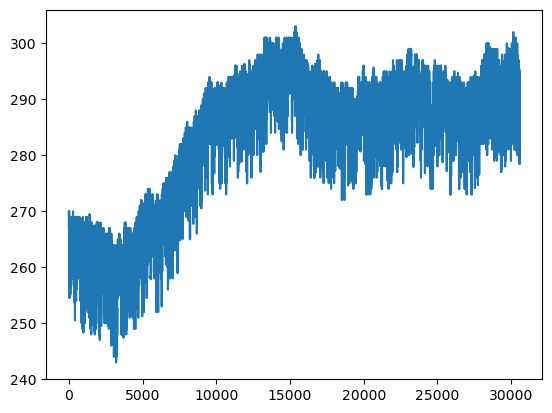

In [4]:
tape1['Price'].plot()

In [5]:
result = adfuller(tape1['Price'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -3.853514
p-value: 0.002405


As p-value is less than 0.05 then model can be assumed stationary and no differencing is needed - this may not hold for less granular data

In [6]:
from pmdarima.arima.utils import ndiffs
ndiffs(tape1['Price'], test='adf')

0

Confirm the significant number of differencing is 0.

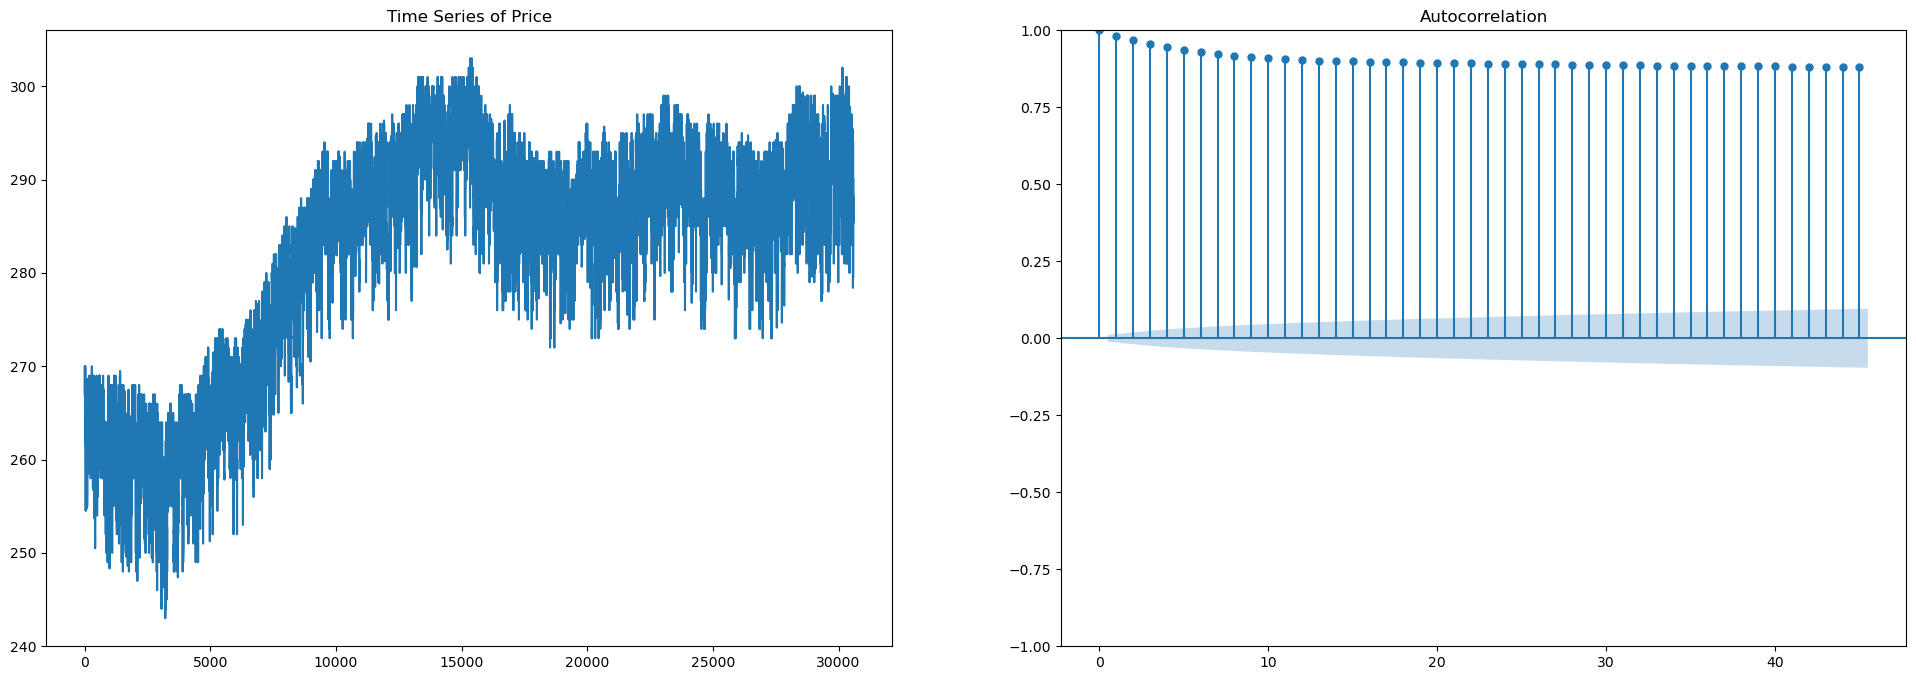

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(tape1['Price'])
ax1.set_title('Time Series of Price')
plot_acf(tape1['Price'], ax=ax2);

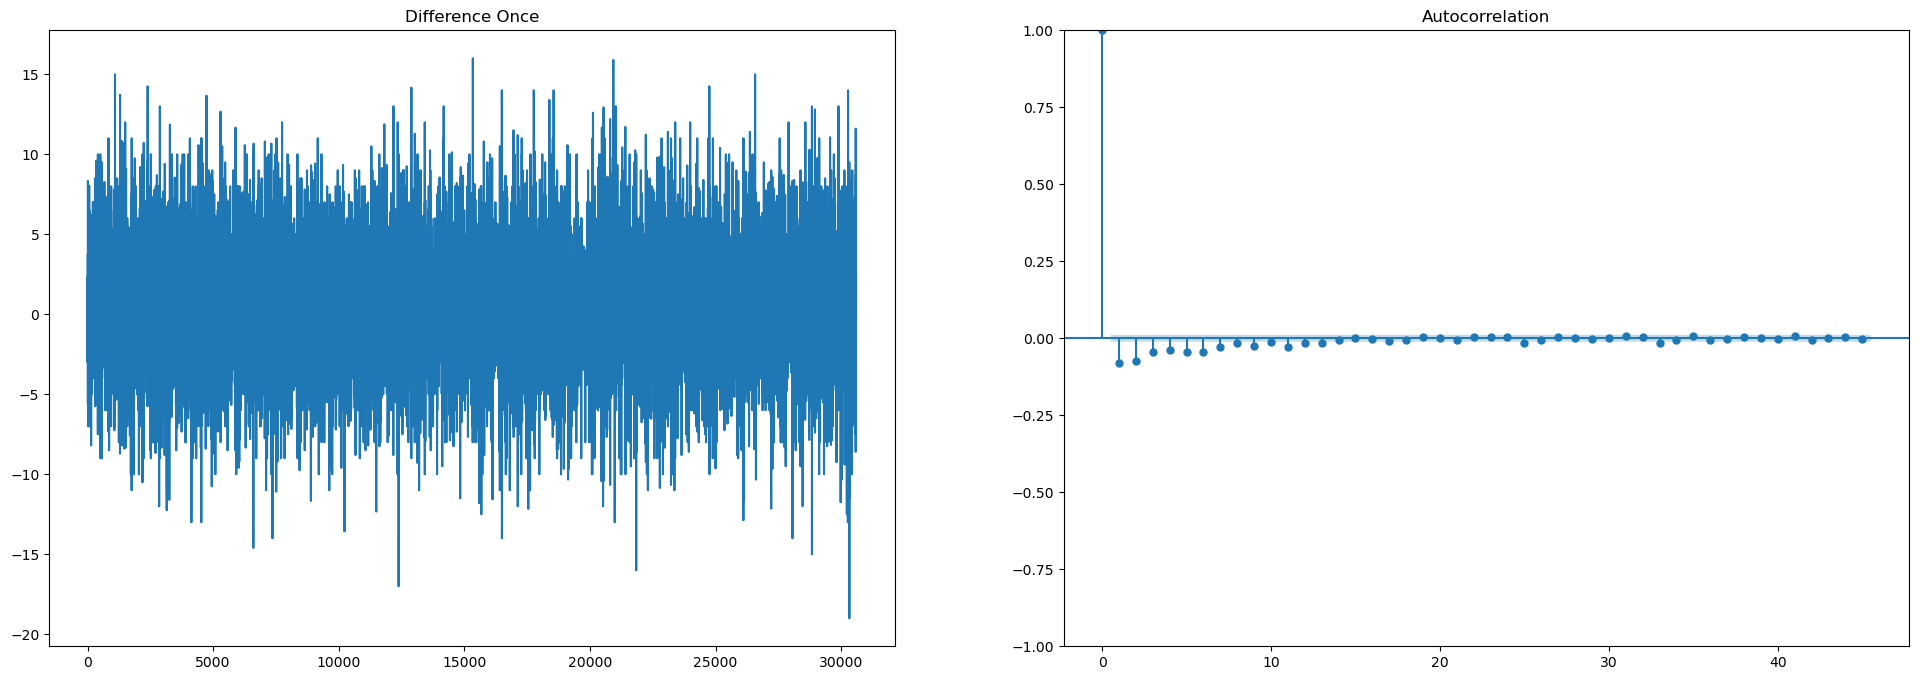

In [8]:
diff = tape1['Price'].diff().dropna()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(diff)
ax1.set_title('Difference Once')
plot_acf(diff, ax=ax2);

Differencing provides a series more celearly centred around mean 0. This will be used for the further investigation despite the original data passing the ADF test. 

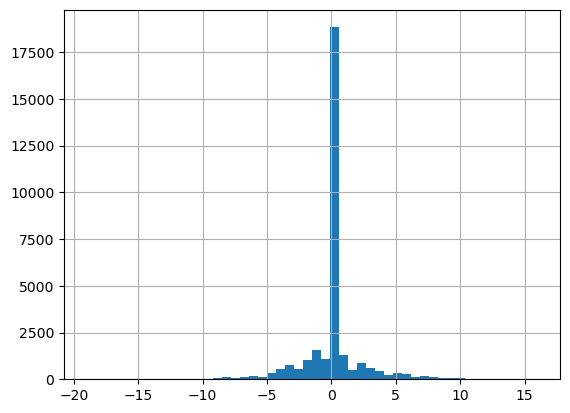

In [9]:
# histogram of differences
diff.hist(bins=50);

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


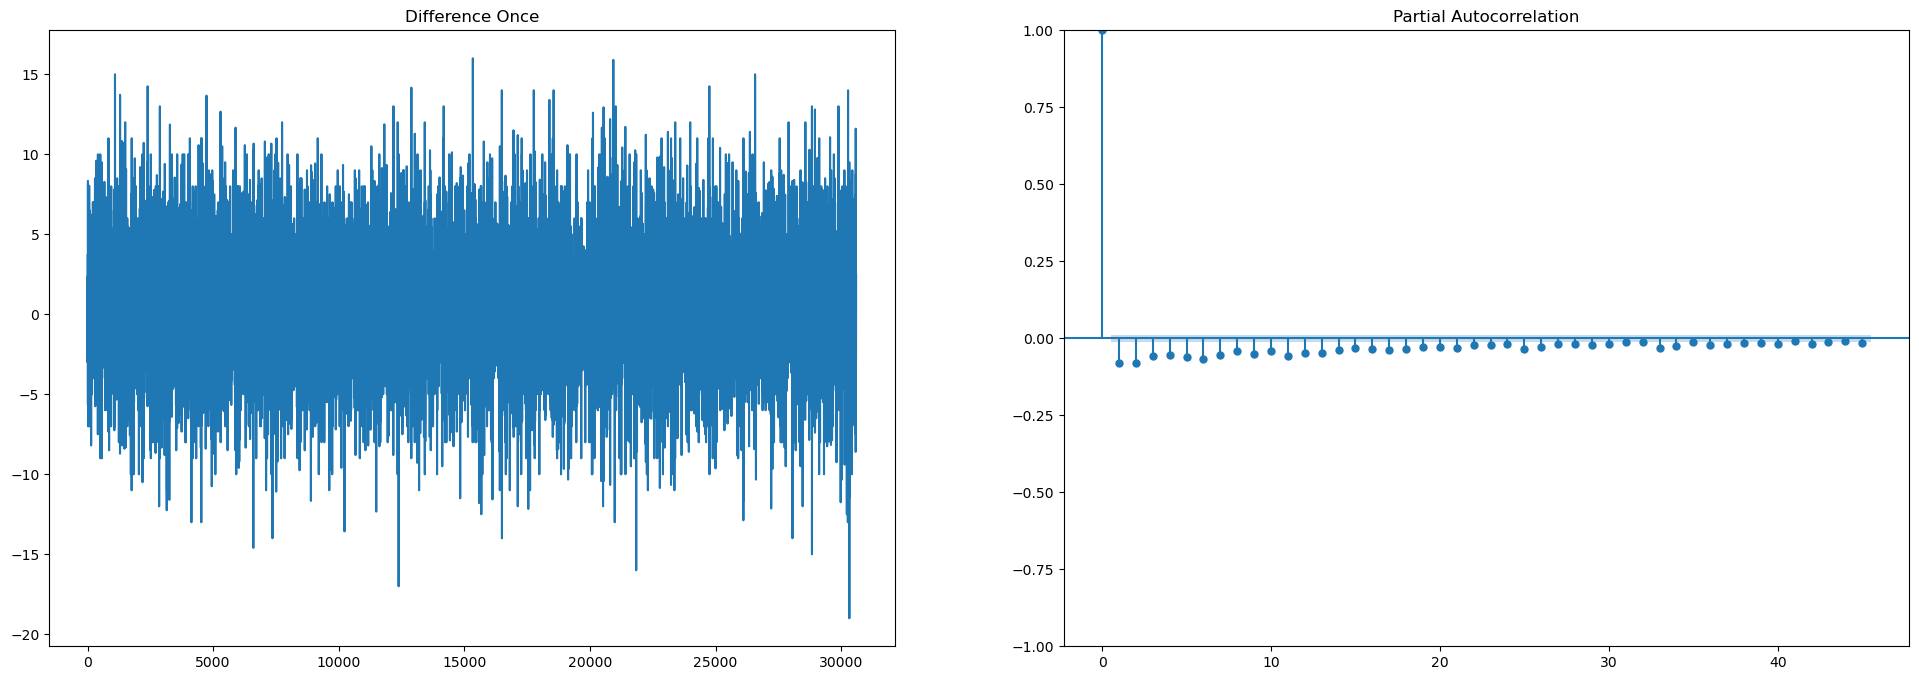

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(diff)
ax1.set_title('Difference Once')
plot_pacf(diff, ax=ax2);

Significant lags in the Auto-Regressive model which begin to die down at order 18. This pacf plot can be used to select the p value of the model.

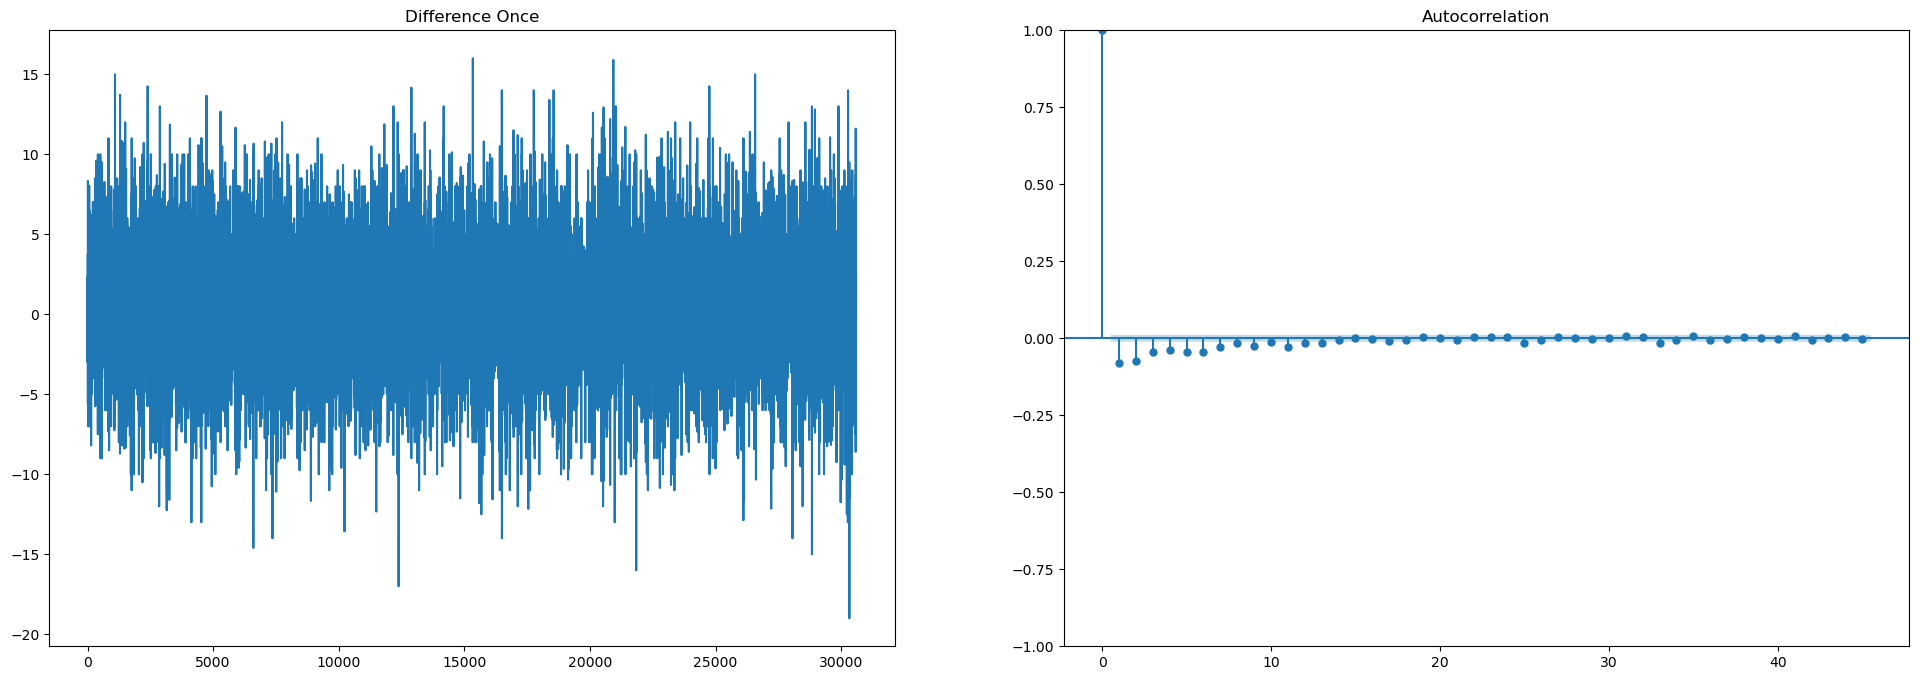

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(diff)
ax1.set_title('Difference Once')
plot_acf(diff, ax=ax2);


Significant lags in Moving Average model until lag 6. This can be used to choose q.

In [12]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA model
model = ARIMA(tape1['Price'], order=(1,0,1))
result = model.fit()

Experimenting with standard (1,0,1) ARIMA model

In [13]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                30590
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -68965.168
Date:                Mon, 12 Feb 2024   AIC                         137938.336
Time:                        13:56:19   BIC                         137971.650
Sample:                             0   HQIC                        137949.015
                              - 30590                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        281.6643      0.850    331.502      0.000     279.999     283.330
ar.L1          0.9856      0.001   1007.350      0.000       0.984       0.988
ma.L1         -0.0854      0.006    -14.916      0.0

Coefficient values are too small and P values are far too high, meaning the components of the model aer not significant enough so need to increase order of AR model and test performance again.

P values are much better in this model and coefficient values higher.

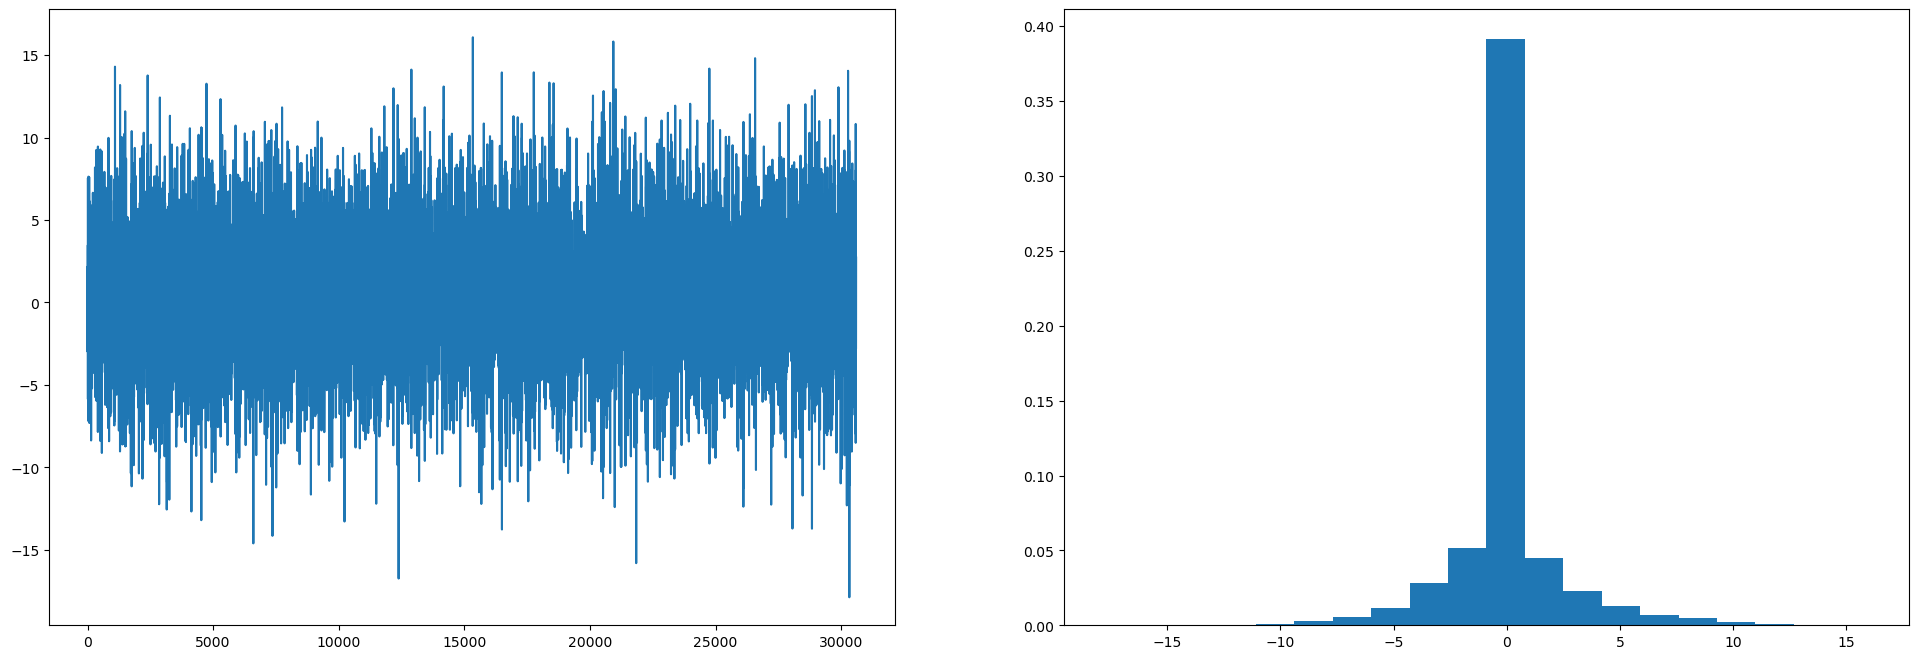

In [14]:
residuals = pd.DataFrame(result.resid)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(residuals[1:])
ax2.hist(residuals[1:], density=True, bins=20);



Text(0.5, 1.0, 'ARIMA Predictions for first 100 time stamps of Tape 1')

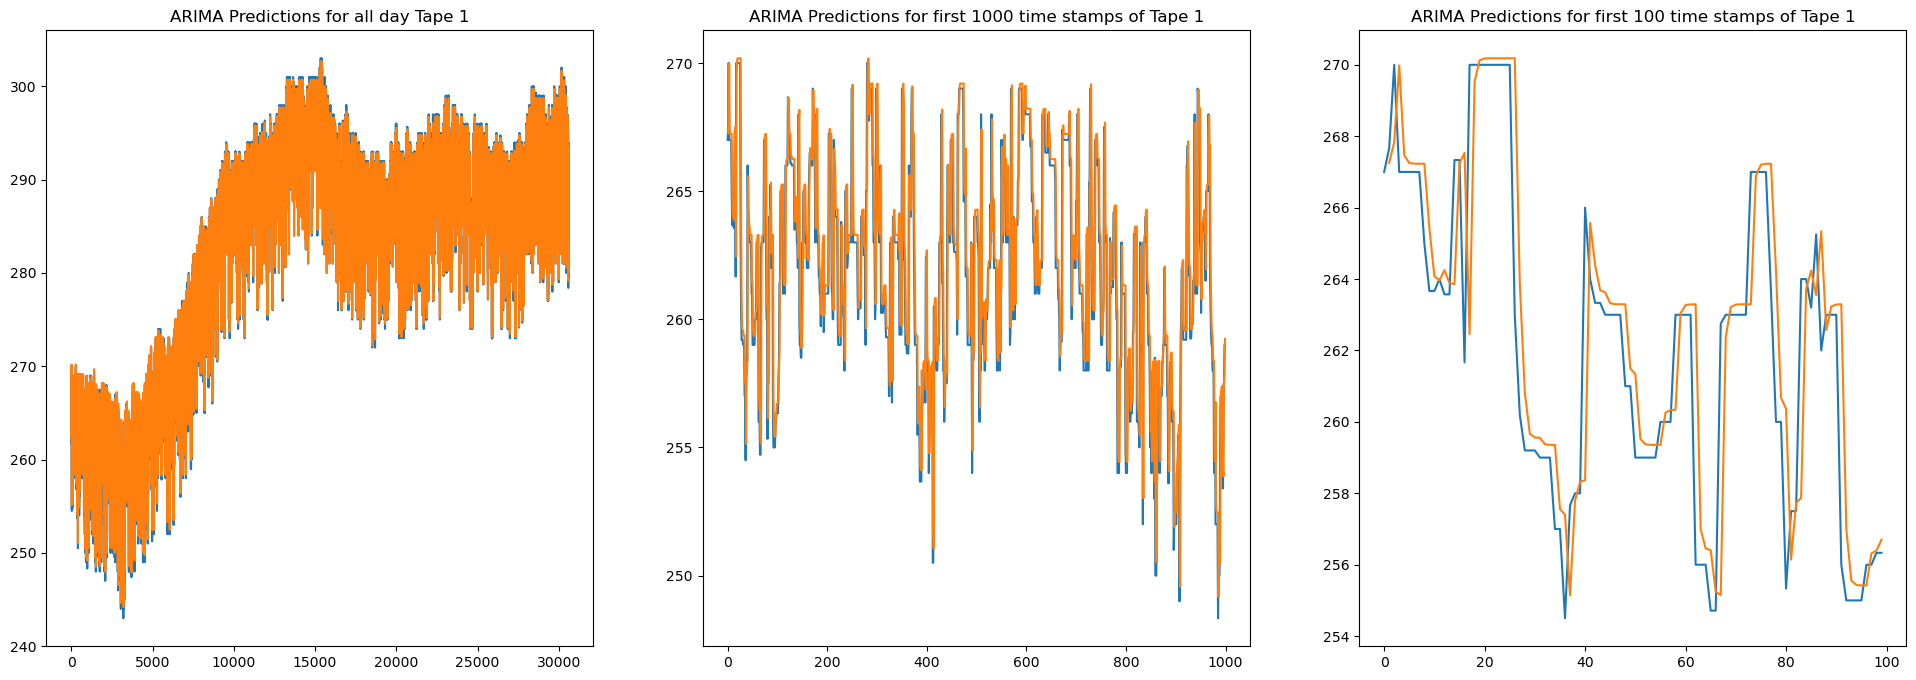

In [15]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))


pred = result.predict(start=0, end=len(tape1)-1)
ax1.plot(tape1['Price'])
ax1.plot(pred[1:])
ax1.set_title('ARIMA Predictions for all day Tape 1')

ax2.plot(tape1['Price'][:1000])
ax2.plot(pred[1:1000])
ax2.set_title('ARIMA Predictions for first 1000 time stamps of Tape 1')



ax3.plot(tape1['Price'][:100])
ax3.plot(pred[1:100]) 
ax3.set_title('ARIMA Predictions for first 100 time stamps of Tape 1')

Need to get the tapes 2 interpolated

In [16]:
tape2 = pd.read_csv("resampled_df_1.csv")

Use the trained model and coefficients on a completely different day and see how it performs

In [17]:
result2 = result.apply(tape2['Price'], refit=False)

result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                30598
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -68231.592
Date:                Mon, 12 Feb 2024   AIC                         136471.185
Time:                        13:56:22   BIC                         136504.500
Sample:                             0   HQIC                        136481.864
                              - 30598                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        281.6643      0.850    331.502      0.000     279.999     283.330
ar.L1          0.9856      0.001   1007.350      0.000       0.984       0.988
ma.L1         -0.0854      0.006    -14.916      0.000      -0.097      -0.074
sigma2         5.3175      0.022    241.828      0.000       5.274       5.361
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):             89227.88
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.30
===================================================================================

Warnings:
[1] Parameters and standard errors were estimated using a different dataset and were then applied to this dataset. Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'ARIMA(1,0,1) Predictions for first 100 time stamps of Tape 2')

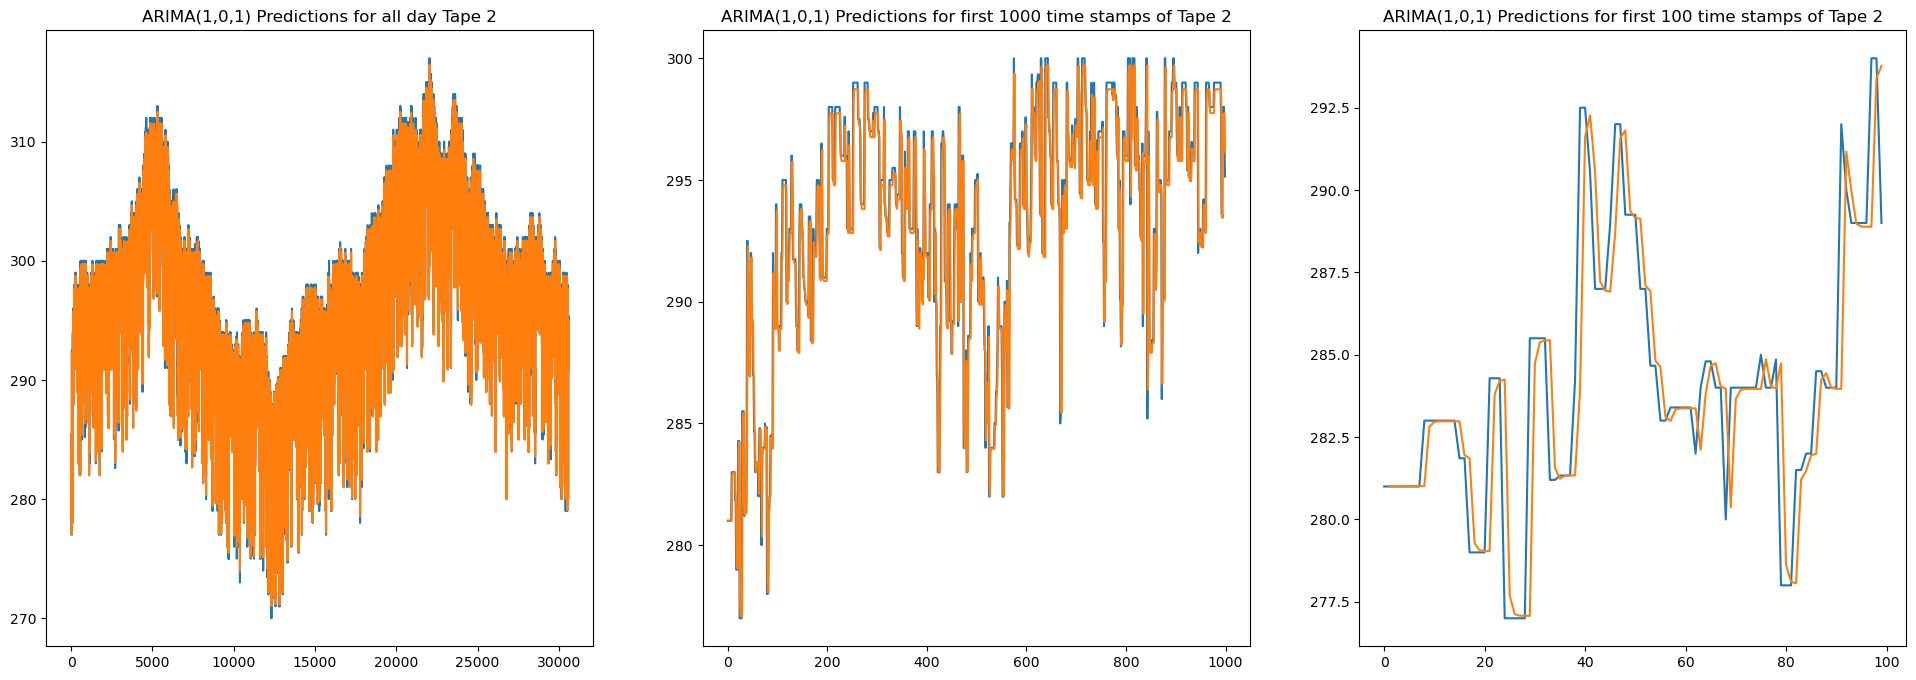

In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))

pred2 = result2.predict(start=0, end=len(tape2)-1)
ax1.plot(tape2['Price'])
ax1.plot(pred2[1:])
ax1.set_title('ARIMA(1,0,1) Predictions for all day Tape 2')

ax2.plot(tape2['Price'][:1000])
ax2.plot(pred2[1:1000])
ax2.set_title('ARIMA(1,0,1) Predictions for first 1000 time stamps of Tape 2')

ax3.plot(tape2['Price'][:100])
ax3.plot(pred2[1:100]) 
ax3.set_title('ARIMA(1,0,1) Predictions for first 100 time stamps of Tape 2')

(array([3.75479444e-05, 2.06513694e-04, 3.37931500e-04, 7.69732860e-04,
        1.46436983e-03, 3.19157527e-03, 7.49081491e-03, 1.79291435e-02,
        4.59774579e-02, 3.80248033e-01, 6.45261425e-02, 2.16276160e-02,
        1.50754997e-02, 7.99771216e-03, 4.56207525e-03, 1.52069175e-03,
        8.63602721e-04, 4.13027388e-04, 1.12643833e-04, 7.50958888e-05]),
 array([-16.84348545, -15.1026209 , -13.36175634, -11.62089178,
         -9.88002723,  -8.13916267,  -6.39829812,  -4.65743356,
         -2.91656901,  -1.17570445,   0.5651601 ,   2.30602466,
          4.04688921,   5.78775377,   7.52861832,   9.26948288,
         11.01034743,  12.75121199,  14.49207655,  16.2329411 ,
         17.97380566]),
 <BarContainer object of 20 artists>)

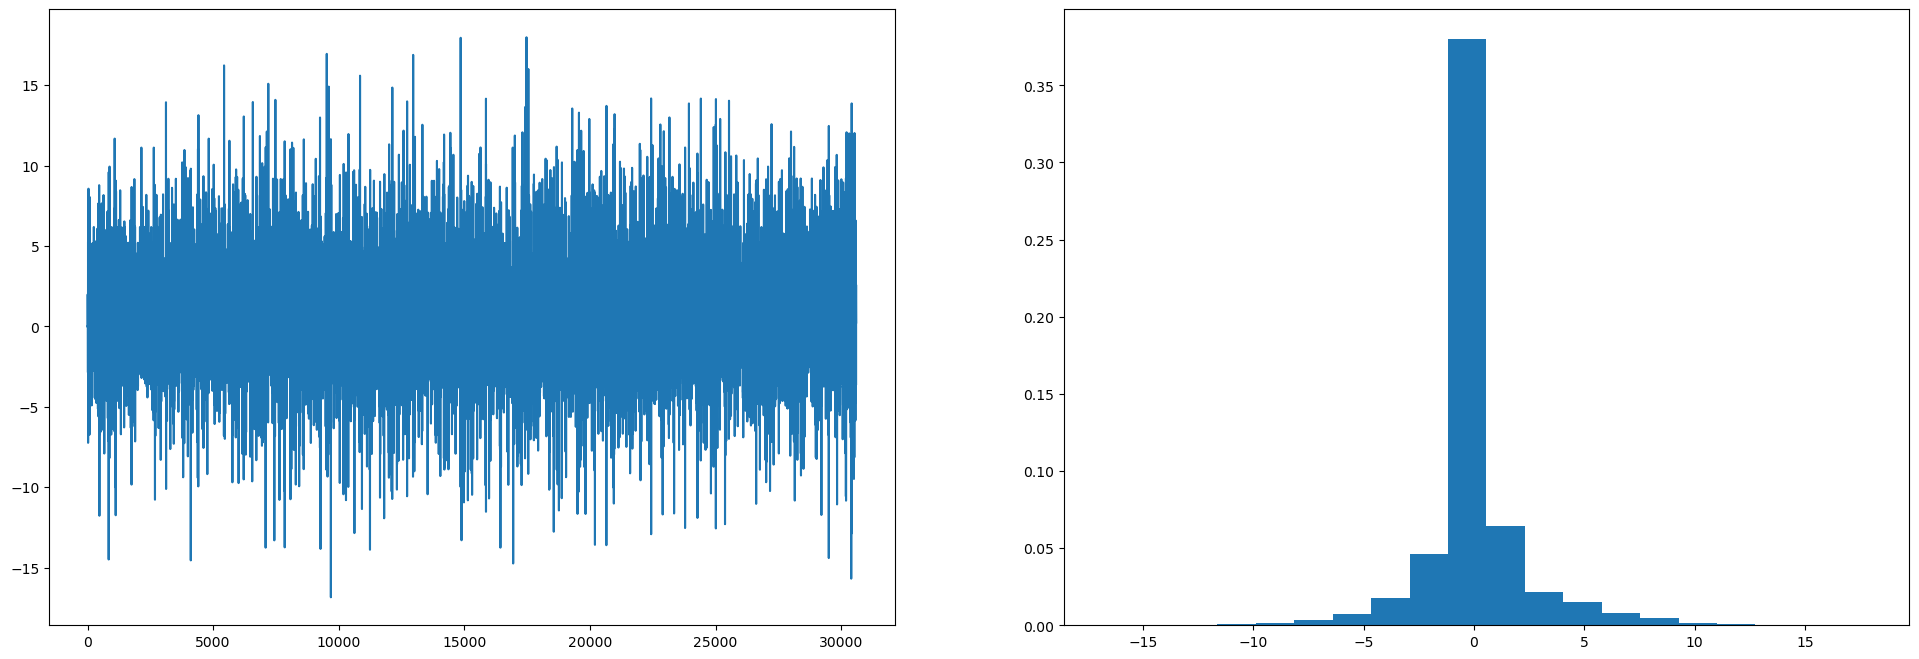

In [19]:
residuals2 = pd.DataFrame(result2.resid)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(residuals2[1:])
ax2.hist(residuals2[1:], density=True, bins=20)

Basic indicator using difference in price predicted

(array([1.45197738e-04, 6.01533485e-04, 2.71727195e-03, 1.50072233e-02,
        2.42729132e-01, 3.97634376e-02, 1.23521790e-02, 3.26694910e-03,
        6.32647286e-04, 1.03712670e-04]),
 array([-15.30962609, -12.15822607,  -9.00682605,  -5.85542602,
         -2.704026  ,   0.44737402,   3.59877404,   6.75017406,
          9.90157408,  13.0529741 ,  16.20437412]),
 <BarContainer object of 10 artists>)

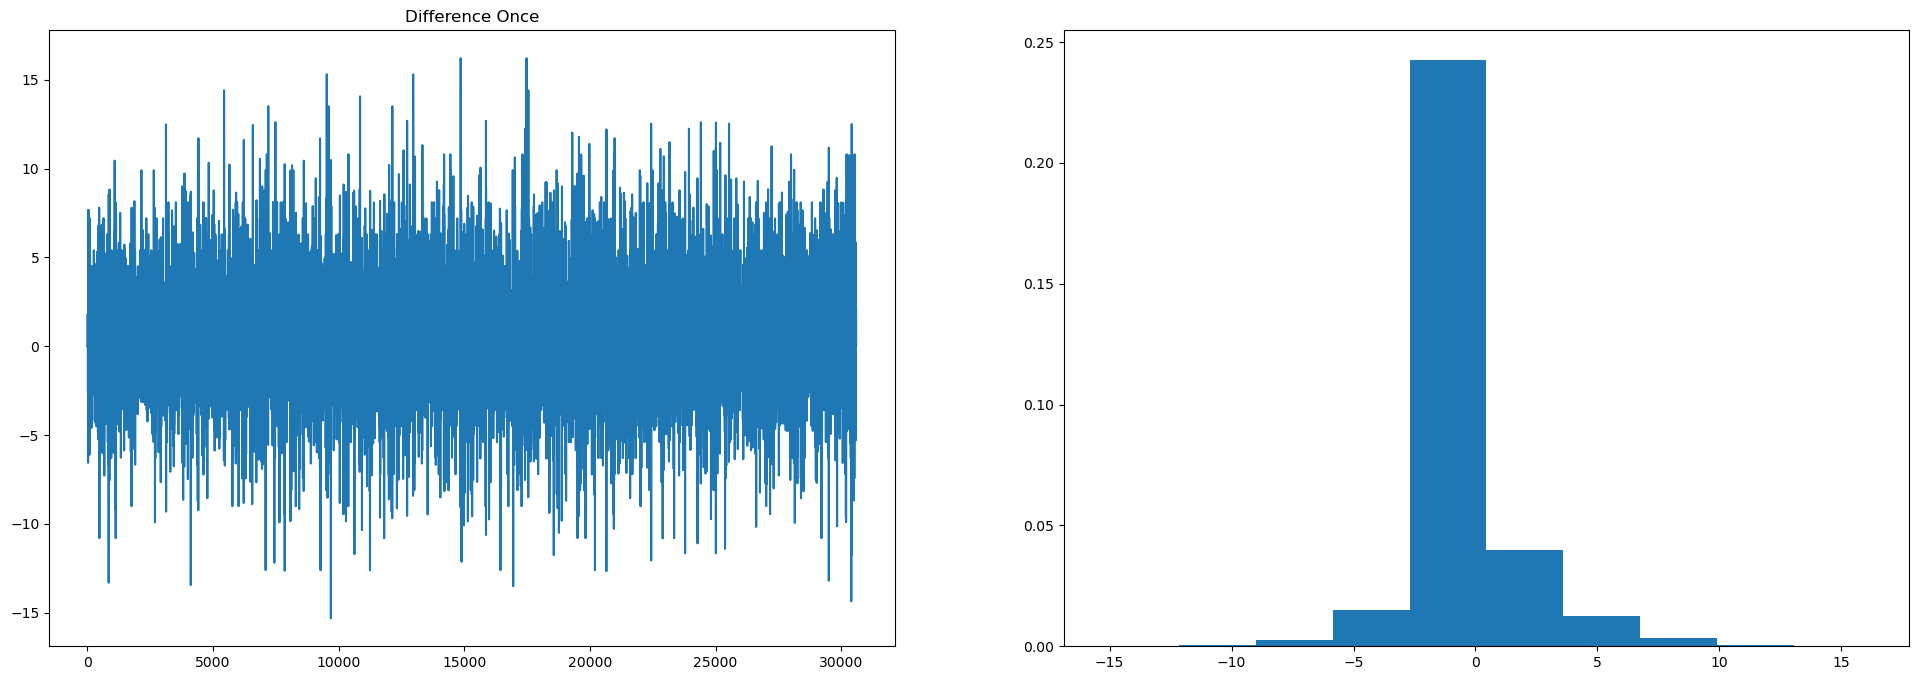

In [20]:
diff2 = pred2.diff().dropna()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(diff2[1:])
ax1.set_title('Difference Once')
ax2.hist(diff2[1:], density=True)

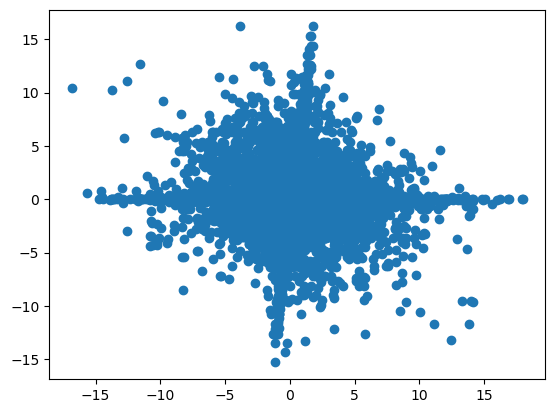

In [21]:
plt.scatter(residuals2[2:], diff2[1:])

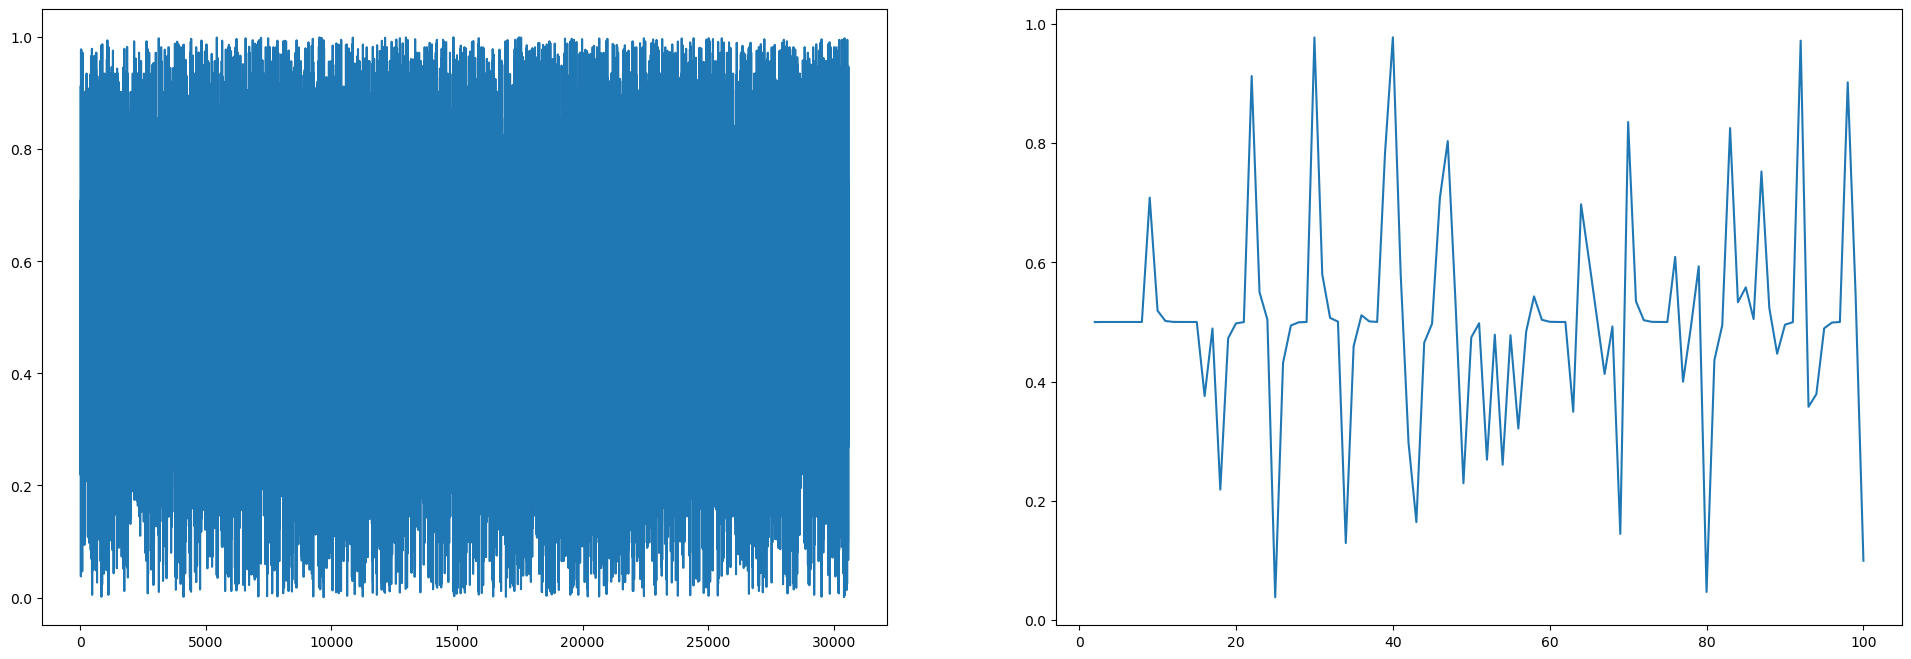

In [22]:
# pass differences through an activation function to get in 0-1 range for buy and sell signals - above 0.5 buy, below 0.5 sell
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# normalise distribtion to normal 
diff2_norm = (diff2 - diff2.mean()) / diff2.std()

singal_diff2 = sigmoid(diff2_norm)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))
ax1.plot(singal_diff2[1:])
ax2.plot(singal_diff2[1:100])

In [23]:
print('Tape 2 Error when trained on Tape 1')
print(f'Mean Absolute Error: {result2.mae}') 
print(f'MSE: {result2.mse}')

Tape 2 Error when trained on Tape 1
Mean Absolute Error: 1.2133316469635973
MSE: 5.056327972613199


Stationary Predicted Count: 3263
Stationary Actual Count: 18356
0.23152596659803248


<AxesSubplot:>

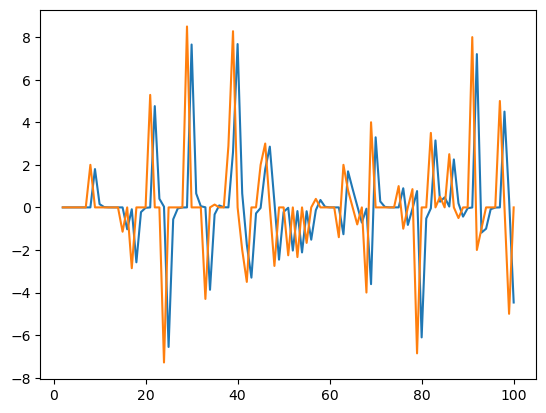

In [35]:
# check how many times signal has correctly predicted movement of actual price

# !!need to ensure that the price movement in in % values not absolute!!

# get actual price movement
actual_diff2 = tape2['Price'].diff().dropna()

pred2 = result2.predict(start=0, end=len(tape2)-1)
diff2 = pred2.diff().dropna()

# check if both are over 1/100 of a % increase
up_correct = (diff2>0.0001) & (actual_diff2>0.0001)
down_correct = (diff2<-0.0001) & (actual_diff2<-0.0001)
stationary_correct = ((diff2<=0.0001) & (diff2>-0.0001)) & ((actual_diff2<=0.0001) & (actual_diff2>-0.0001))

print(f"Stationary Predicted Count: {sum((diff2<=0.0001) & (diff2>-0.0001))}")
print(f"Stationary Actual Count: {sum(((actual_diff2<=0.0001) & (actual_diff2>-0.0001)))}")

#correct = diff2_high*actual_diff2 > 0 # correct if direction is the same
#print(f"Stationary Predicted Count: {sum(diff2_high== 0)}")
#print(f"Stationary Actual Count: {sum(actual_diff2== 0)}")
# must also check if both are zero
#correct = correct | (diff2_high == 0) & (actual_diff2 == 0)
correct = up_correct | down_correct | stationary_correct

print(correct.sum()/len(correct))

diff2[1:100].plot()  
actual_diff2[1:100].plot()

In [25]:
model_high = ARIMA(tape1['Price'], order=(4,1,4))
result_high = model_high.fit()

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [26]:
result2_high = result_high.apply(tape2['Price'], refit=False)
result2_high.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                30598
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -67352.952
Date:                Mon, 12 Feb 2024   AIC                         134723.904
Time:                        13:57:13   BIC                         134798.862
Sample:                             0   HQIC                        134747.933
                              - 30598                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0968      0.317     -0.306      0.760      -0.717       0.524
ar.L2          0.0916      0.285      0.322      0.748      -0.466       0.649
ar.L3          0.0203      0.281      0.072      0.942      -0.530       0.571
ar.L4          0.5118      0.238      2.152      0.031       0.046       0.978
ma.L1         -0.0476      0.318     -0.150      0.881      -0.671       0.576
ma.L2         -0.2305      0.318     -0.725      0.468      -0.854       0.393
ma.L3         -0.1113      0.296     -0.376      0.707      -0.691       0.468
ma.L4         -0.5802      0.278     -2.090      0.037      -1.124      -0.036
sigma2         5.0402      0.024    213.376      0.000       4.994       5.087
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):             72787.36
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.54
===================================================================================

Warnings:
[1] Parameters and standard errors were estimated using a different dataset and were then applied to this dataset. Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
print('Tape 2 Error when trained on Tape 1')
print(f'Mean Absolute Error: {result2_high.mae}') 
print(f'MSE: {result2_high.mse}')

Tape 2 Error when trained on Tape 1
Mean Absolute Error: 1.2904596442175837
MSE: 7.3547572211877545


In [34]:
pred2_high = result2_high.predict(start=0, end=len(tape2)-1)
diff2_high = pred2_high.diff().dropna()

# check if both are over 1/100 of a % increase
up_correct = (diff2_high>0.0001) & (actual_diff2>0.0001)
down_correct = (diff2_high<-0.0001) & (actual_diff2<-0.0001)
stationary_correct = ((diff2_high<=0.0001) & (diff2_high>-0.0001)) & ((actual_diff2<=0.0001) & (actual_diff2>-0.0001))

print(f"Stationary Predicted Count: {sum((diff2_high<=0.0001) & (diff2_high>-0.0001))}")
print(f"Stationary Actual Count: {sum(((actual_diff2<=0.0001) & (actual_diff2>-0.0001)))}")

#correct = diff2_high*actual_diff2 > 0 # correct if direction is the same
#print(f"Stationary Predicted Count: {sum(diff2_high== 0)}")
#print(f"Stationary Actual Count: {sum(actual_diff2== 0)}")
# must also check if both are zero
#correct = correct | (diff2_high == 0) & (actual_diff2 == 0)
correct = up_correct | down_correct | stationary_correct

print(correct.sum()/len(correct))

Stationary Predicted Count: 47
Stationary Actual Count: 18356
0.1899532633918358


Use the model to make out of sample predictions

In [83]:
model = ARIMA(tape2['Price'][:20000], order=(4,1,4))
result3 = model.fit()

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [84]:
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                20000
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -49008.675
Date:                Thu, 01 Feb 2024   AIC                          98035.350
Time:                        11:58:38   BIC                          98106.481
Sample:                             0   HQIC                         98058.622
                              - 20000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5268      1.486     -0.355      0.723      -3.439       2.386
ar.L2          0.8138      0.816      0.997      0.319      -0.785       2.413
ar.L3          0.5113      1.243      0.412      0.681      -1.924       2.947
ar.L4         -0.1579      0.302     -0.523      0.601      -0.749       0.433
ma.L1          0.1950      1.486      0.131      0.896      -2.717       3.107
ma.L2         -1.1248      1.174     -0.958      0.338      -3.426       1.177
ma.L3         -0.3912      1.419     -0.276      0.783      -3.173       2.391
ma.L4          0.3367      0.618      0.545      0.586      -0.874       1.548
sigma2         7.8707      0.053    147.567      0.000       7.766       7.975
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9169.75
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Text(0.5, 1.0, 'ARIMA(4,1,6) Predictions for first 100 time stamps of Tape 1')

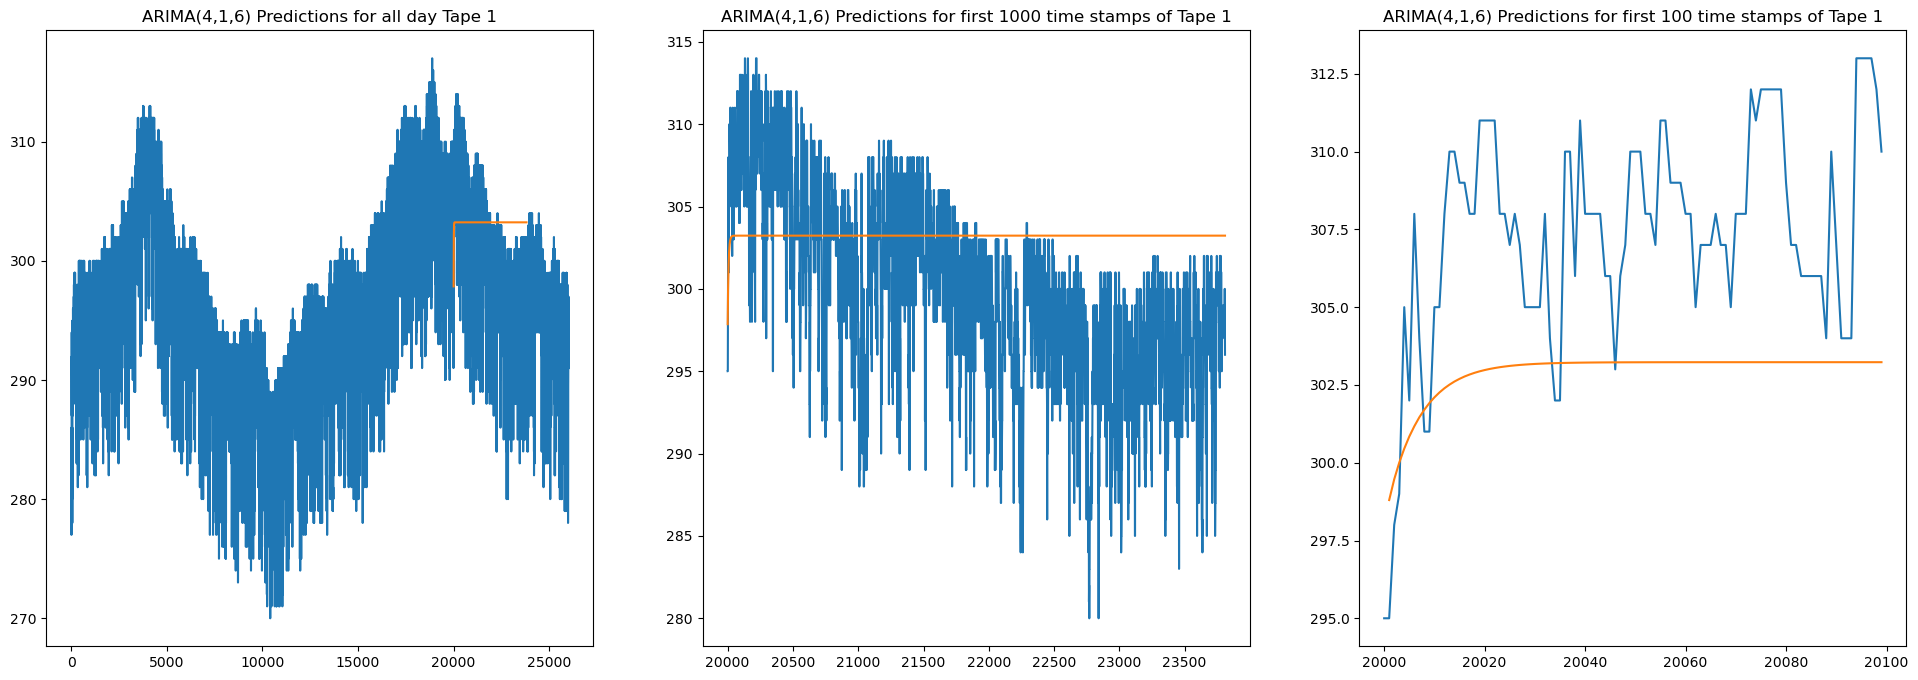

In [85]:
pred2 = result3.forecast(steps = 3810)
forecast_range = np.arange(20000,23810)
total_range = np.arange(0,26009)

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))

ax1.plot(total_range,tape2['Price'])
ax1.plot(forecast_range,pred2)
ax1.set_title('ARIMA(4,1,6) Predictions for all day Tape 2')

ax2.plot(forecast_range,tape2['Price'][20000:23810])
ax2.plot(forecast_range,pred2)
ax2.set_title('ARIMA(4,1,6) Predictions for first 1000 time stamps of Tape 2')

ax3.plot(np.arange(20000,20100),tape2['Price'][20000:20100])
ax3.plot(pred2[1:100]) 
ax3.set_title('ARIMA(4,1,6) Predictions for first 100 time stamps of Tape 2')